In [8]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import torch
from torch import nn
from torch.nn.init import calculate_gain

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
torch.set_default_dtype(torch.float32)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [5]:
from models.MLP import Davies2021
net = Davies2021(N_layers=8, width=28, activation=nn.Softplus(30), last_activation=nn.Softplus(30)).to(device)
#net = Davies2021(N_layers=8, width=28, activation=nn.SiLU(), last_activation=nn.Identity()).to(device)


In [5]:
import os
from utils.dataset_generator import ImplicitDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
print(train_dataset)

# filter out discontinous points
# grads = train_dataset.grads
# norm_grad = torch.linalg.norm(grads, dim=1)
# mark = torch.logical_and(norm_grad > 0.9, norm_grad < 1.05)
# grads = grads[mark]
# points = train_dataset.points[mark]
# sdfs = train_dataset.sdfs[mark]

ImplicitDataset (64000 points)


In [ ]:
from utils.callback_scheduler import CallbackScheduler

# Optimization
## ADA
torch.nn.utils.clip_grad_norm_(net.parameters(), 10.0)
optimizer=torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=30, max_eval=60, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [ ]:
from utils.dataset_generator import batch_loader

max_epochs = 5000
PRINT_EVERY_EPOCH = 100

#points.requires_grad_(True)
try:
    epoch = 0
    while epoch < max_epochs:
        #for points, sdfs in batch_loader(train_dataset.points, train_dataset.sdfs, batch_size=10000):
            # Training
            lr_scheduler.optimizer.zero_grad()
            #points.requires_grad_(True)
            loss = net.loss(train_dataset.points, train_dataset.sdfs)
            loss.backward()

            lr_scheduler.optimizer.step(lambda: loss)
            lr_scheduler.step_when((epoch % 500) == 499, verbose=True)
            if epoch % PRINT_EVERY_EPOCH == 0:
                print(f'#{epoch} Loss: {net._loss:.6f}')

            epoch += 1
except KeyboardInterrupt as e:
    print('Bye bye')


In [6]:
#torch.save(net.state_dict(), './MLP_5000.pth')
net.load_state_dict(torch.load('./MLP_5000.pth'))

<All keys matched successfully>

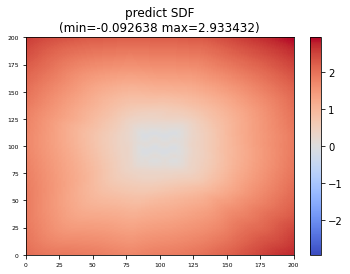

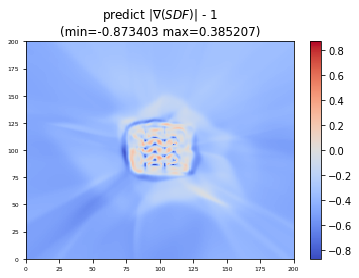

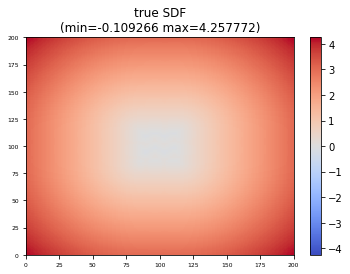

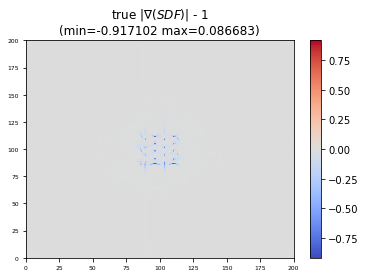

In [6]:
from utils.visualizer import SDFVisualize
net.to(device)
visualize = SDFVisualize(z_level=0.0, scale_offset=3, nums=200, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)

In [17]:
from utils.dataset_generator import TestDataset, run_batch
dataset_name = '../datasets/box_1f0_gyroid_4pi'
test_dataset = TestDataset(dataset_name+'_test.npz', device=device)
kwarg = {'reducer': torch.mean, 'batch_size': 10000}
#print('Train residual: ', net.test_residual(train_dataset.points).cpu().detach().numpy())
print('Test uniform SDFS: ', run_batch(net.test, test_dataset.uniform.points, test_dataset.uniform.sdfs, **kwarg).cpu().detach().numpy())
print('Test uniform residual:', run_batch(net.test_residual, test_dataset.uniform.points, **kwarg).cpu().detach().numpy())
print('Test uniform norm grads: ', run_batch(net.test_norm_gradient, test_dataset.uniform.points, test_dataset.uniform.norm_grads, **kwarg).cpu().detach().numpy())
print('Test random SDFS: ', run_batch(net.test, test_dataset.random.points, test_dataset.random.sdfs, **kwarg).cpu().detach().numpy())
print('Test random residual: ', run_batch(net.test_residual, test_dataset.random.points, **kwarg).cpu().detach().numpy())
#print('Actual uniform residual: ', torch.mean((test_dataset.uniform.gradients - 1)**2).cpu().detach().numpy())

Test uniform SDFS:  5.3824082e-05
Test uniform residual: 0.18620273
Test uniform norm grads:  0.050732527
Test random SDFS:  0.009150554
Test random residual:  0.23436302
